In [2]:
from bggcomplex import *
from lie_algebra_module import *
from quantum_center_module import QuantumFactory
from bgg_cohomology import BGGCohomologyComputer
import numpy as np
import scipy
from collections import defaultdict
from time import time
from sympy.utilities.iterables import subsets

In [3]:
BGG = BGGComplex("A3")
BGG.find_cycles();

In [4]:
BGG.compute_signs();

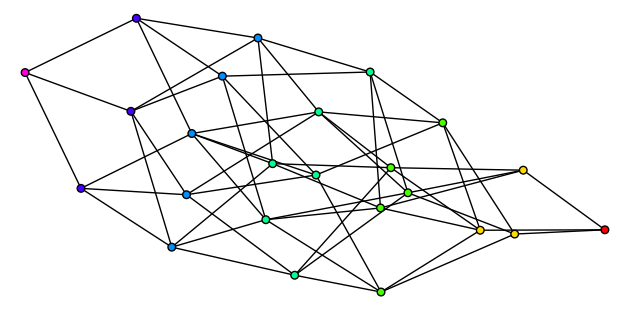

In [5]:
BGG.plot_graph().plot()

We want to implement the $U(\mathfrak g)$ action on the module
$$
    M_i^j=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j+\frac k2}\mathfrak n \right) \right)
$$
For this we need two things, one is finding a basis of this module, and second we define the action on it. Unfortunately I can't find a good out of the box implementation for either of these, so we are going to have to do it ourselves. Ideally we can use this to extend sage a little bit. 

Sagemath has a class FreeModuleTensor, it can deal with alternating and symmetric tensors. But it specifically says it can not deal with tensor products of different modules, whereas that is precisely what we need. We should investigate how this class work, and extend it with this functionality. Besides, that module seems to focus on doing stuff without a specific basis. We want to do everything in a basis, because the whole point is to compute a basis. 

We should make an instance of CombinatorialFreeModule

Next steps:
- compute phi (there is a slight discrepency between this phi and the one in Mathematica. might be because here we choose a more reasonable basis)
- construct M
- construct submodule T
- take quotients by subspaces
- compute dot regular weights
- attach it to BGG complex, compute (co)kernel dimensions

### Definition of coadjoint action

We have a pairing $\langle\,\,,\,\rangle$ on $\mathfrak g$. We also have a map on the root space, ${}^*$ sending:
$e_I \leftrightarrow f_I$, $h_i\leftrightarrow h_i$. Then the coadjoint action, corestricted to a subalgebra $\mathfrak i<\mathfrak g$ with basis $\{\alpha_i\}$,
$$
 \left.\mathrm{ad}^*\right|_{\mathfrak{i}}(X)(m) =- \sum_i\langle m,\,[X,\alpha_i^*] \rangle\alpha_i
$$
The pairing is defined by $\langle e_I,f_I\rangle=\delta_{i,j}$ and $\langle h_i,h_j\rangle=\delta_{i,j}$. We also define
$$
\varphi:\mathfrak b\to\mathfrak n\otimes\mathfrak u,\quad \varphi(m)=\sum_I f_I\otimes \left.\mathrm{ad}^*\right|_{\mathfrak{u}}(m)(e_I)
$$
Note that the image of $\varphi$ is weight zero.

In [26]:
basis = sorted(BGG.LA.basis().list()[:3])

In [27]:
q_factory = QuantumFactory(BGG,simple_root_subset=set([]))
q_factory.get_weight

<bound method QuantumFactory.get_weight of <quantum_center_module.QuantumFactory object at 0x6fd14c0b950>>

In [28]:
factory = LieAlgebraModuleFactory(BGG.LA)
_,u_mod = factory.parabolic_u_module(set([]))
basis_length = len(u_mod.basis())
def exterior_power(j):
    return WeightModuleWithRelations(QQ, u_mod.alternating_power(j), q_factory.get_weight)
for i in range(0,basis_length+1):
    for j in range(basis_length+1):
        cohomology_computer = BGGCohomologyComputer(BGG,exterior_power(j))
        print('(%d,%d)'%(i,j)+'-'*30)
        cohom = cohomology_computer.compute_full_cohomology(i)
        print('i=%d, j=%d, cohomology = %s' %(i,j, cohom))


(0,0)------------------------------
i=0, j=0, cohomology = [(0, 1)]
(0,1)------------------------------
i=0, j=1, cohomology = [(alpha[1] + alpha[2] + alpha[3] + alpha[4], 1)]
(0,2)------------------------------


KeyboardInterrupt: 

# The module M

Recall:
$$
    M_j^k=\bigoplus{}_{r=0}^{j+\frac k2}\left(\left(\bigodot{}^{j+\frac k2-r}\mathfrak u \right)\otimes\left(\bigwedge^r\mathfrak g\right)\otimes\left(\bigwedge{}^{j-r}\mathfrak n \right) \right)
$$

In [29]:
q_factory = QuantumFactory(BGG,simple_root_subset=set([]))

In [30]:
q_factory.compute_cohomology_block()

(2, 0)
made a weight module of size: 10, with 0 relations)
(2, 0, [(0, 4)])
(4, 0)
made a weight module of size: 45, with 0 relations)
(4, 0, [(0, 9)])
(6, 0)
made a weight module of size: 120, with 0 relations)
(6, 0, [(0, 15)])
(8, 0)
made a weight module of size: 210, with 0 relations)
(8, 0, [(0, 20)])
(10, 0)
made a weight module of size: 252, with 0 relations)
(10, 0, [(0, 22)])
(12, 0)
made a weight module of size: 210, with 0 relations)
(12, 0, [(0, 20)])
(14, 0)
made a weight module of size: 120, with 0 relations)
(14, 0, [(0, 15)])
(16, 0)
made a weight module of size: 45, with 0 relations)
(16, 0, [(0, 9)])
(18, 0)
made a weight module of size: 10, with 0 relations)
(18, 0, [(0, 4)])
(20, 0)
made a weight module of size: 1, with 0 relations)
(20, 0, [(0, 1)])
(4, 2)
made a weight module of size: 2280, with 630 relations)
(4, 2, [(0, 5)])
(6, 2)
made a weight module of size: 4980, with 1680 relations)
(6, 2, [(0, 14)])
(8, 2)
made a weight module of size: 7560, with 2940 rela

KeyboardInterrupt: 

In [ ]:
q_factory.timer

In [ ]:
factory = q_factory.factory

We should have a new class WeightModule which is an extension of LieAlgebraModule, but has the function get_weight. Then we should make a new module, compute_bgg_cohomology which takes a BGG and WeightModule as input to compute BGG.

How to compute cohomology:
- We start with a weight module E. Nothing is assumed about it.
- We first of all compute all the dot regular weights of E. 
- For each dot regular weight $\mu$, define the length $\ell(\mu)$ as the length of the unique $w\in W$ such that $w\cdot\mu$ is dominant. 
- We make a list of tuples $(\mu,\,w\cdot \mu,\,\ell(\mu))$
- Let's say we want to compute cohomology in degree i. We create a list $H^i(E)$ = `[ ]`
- We select all $(\mu,\,w\cdot \mu,\,\ell(\mu))$ with $\ell(\mu)=i$
- We compute $H^i(\mathrm{BGG}(E,w\cdot\mu))$
    - If there are no $(\mu',\,w'\cdot \mu',\,\ell(\mu))$ with $w'\cdot\mu'=w\cdot \mu$ and $\ell(\mu')=i\pm 1$, then
    a priori we know that $H^i(\mathrm{BGG}(E,w\cdot\mu)) = E[\mu]$, so we just add $(\mu,\dim E[\mu])$ to the list $H^i(E)$.
    
Now assume that $\lambda=w\cdot \mu$ is a dot-regular dominant weight. 

How to compute $H^i(\mathrm{BGG}(E,\lambda))$:
- Recall that vertices of the BGG graph are labeled by elements $w\in W$. Given a regular (dominant) weight $\mu$ we get can associate to each vertex the $\mathfrak{n}$-module $E[w\cdot \lambda]$. 
- We can also associate to each edge $a\colon w\to w'$ an element $F(a)$ in $U(\mathfrak n)$ and a sign $\sigma(a)\in\{+1,-1\}$. We have $F(a)\cdot E[w\cdot \lambda]\subset E[w'\cdot \lambda]$.
- We define the column $\mathrm{BGG}_i = \bigoplus_{\ell(w)=i}E[w\cdot \lambda]$
- We define the map $\delta\colon\mathrm{BGG}_i\to\mathrm{BGG}_{i+1}$ by $\sum_{\ell(w)=i}\sum_{s(a)=w}\sigma(a)F(a)$
- We want to compute $\dim H^i = \dim \ker \delta_i - \dim \,\mathrm{coker} \delta_{i-1} =\dim \mathrm{BGG}_i-\dim \,\mathrm{coker} \delta_i-\dim \,\mathrm{coker} \delta_{i-1}$
- Actually these are the maps on the weight module $M$, but we need them on $E$. For each weight we have a short exact sequence $T^j_k[\mu]\to M^j_k[\mu]\to E^j_k[\mu]$. We need to find the projection/section here. Call the section $s_\mu:E^j_k[\mu]\to M^j_k[\mu]$. Then we need to compute the kernels of the maps
$$\widetilde{\delta}_i= \sum_{\ell(w)=i}\sum_{a\colon w\to w'}s_{w'\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w\cdot \lambda}$$
$$\widetilde{\delta}^\top_{i-1}= \sum_{\ell(w)=i}\sum_{a\colon w'\to w}s_{w\cdot\lambda}^\top\,\sigma(a)F(a)\,s_{w'\cdot \lambda}$$

## Parabolic subalgebras

Let's first start with the classification of parabolic subalgebras. According to Knapp p.325 they are always of the following form. Let $\Gamma$ be the positive cone spanned by a subset $\Pi'\subset \Pi$ of the simple roots. Then 

$$ \mathfrak{p}=\mathfrak{b}\oplus \bigoplus_{\beta\in\Gamma} \mathfrak{g}_\beta=\mathfrak{b}\oplus \mathfrak{u}_\Gamma$$

Here $\mathfrak{b}=\mathfrak{h}\oplus\mathfrak{n}$ is the Borel subalgebra. Essentially we don't just take $\mathfrak{b}$, but we also add a bunch of $e_\alpha$, given by $\mathfrak{u}_\Gamma$. All parabolic subalgebras are of this form, but this is not a classification. We also define $\mathfrak{n}_\alpha$ to be dual to this, $\mathfrak{n}_\alpha = \langle f_\alpha\,|\,\alpha\notin \Gamma\rangle$


In notation of Knapp:
$$\mathfrak{u}  = \langle e_\alpha\,|\,\alpha\notin \Gamma\rangle$$
$$\mathfrak{l} = \mathfrak{h}\oplus \langle f_\alpha\,|\,\alpha\in -\Gamma\rangle\oplus \langle e_\alpha\,|\,\alpha\in \Gamma\rangle$$
And we note that $\mathfrak{p}=\mathfrak{u}\oplus\mathfrak{l}$

In [ ]:
simple_roots = BGG.lattice.alpha()

involution = {i:len(simple_roots)-i+1 for i in simple_roots.keys()}    

subsets_up_to_involution = list()
for subset in subsets(simple_roots.keys()):
    involution_image = tuple(sorted(involution[i] for i in subset))
    if involution_image not in subsets_up_to_involution:
        subsets_up_to_involution.append(subset)
subsets_up_to_involution

# Fast modules

In [9]:
from fast_module import *
f_factory = FastModuleFactory(BGG.LA)

u_basis = f_factory.parabolic_u_basis()
n_basis = f_factory.parabolic_n_basis()
p_basis = f_factory.parabolic_p_basis()
g_basis = f_factory.g_basis

component_dic = {'u':f_factory.build_component('u','coad'), 
                 'n':f_factory.build_component('n','ad'), 
                 'g':f_factory.build_component('g','ad')}
#components = [[("u", 2, 1),("g",3,2),("n",2,2)],[("u", 3, 1),("g",2,2),("n",1,2)]]
components = [[("u",3,'wedge')]]
module = FastLieAlgebraCompositeModule(f_factory.weight_dic, components, component_dic)

In [11]:
module.dimensions

{(0, 2, 2): 1,
 (1, 1, 1): 1,
 (1, 1, 2): 1,
 (1, 2, 1): 2,
 (1, 2, 2): 2,
 (1, 2, 3): 1,
 (1, 3, 1): 1,
 (1, 3, 2): 1,
 (2, 1, 1): 1,
 (2, 1, 2): 1,
 (2, 2, 0): 1,
 (2, 2, 1): 2,
 (2, 2, 2): 2,
 (2, 3, 1): 1,
 (2, 3, 2): 1,
 (3, 2, 1): 1}

In [10]:
cohom = BGGCohomology(BGG, module)

cohom.cohomology_LaTeX(0,complex_string=r'\wedge^3\mathfrak u')

<IPython.core.display.Math object>

In [7]:
%%prun
for j in range(len(u_basis)+1):
    components = [[("u",j,'wedge')]]
    module = FastLieAlgebraCompositeModule(f_factory.weight_dic, components, component_dic)
    cohom = BGGCohomology(BGG,module)
    for i in range(len(u_basis)+1):
        #cohom.cohomology(i)
        cohom.cohomology_LaTeX(i,complex_string=r'\wedge^{%d}\mathfrak{u}'%j,only_non_zero=True)
        

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
#!pip install numpy-indexed --user

In [ ]:
from sympy.utilities.iterables import subsets
import itertools 

q_factory = QuantumFactory(BGG,simple_root_subset=set([]))

g_dict = {s:i for i,s in enumerate(q_factory.factory.basis['g'])}

weight_dic = {i:BGG.alpha_sum_to_array(q_factory.get_weight(s)) for s,i in g_dict.items()}

In [ ]:
import numpy_indexed as npi
from IPython.display import display, Math, Latex

class FastLieAlgebraCompositeModule:
    """A faster version of Lie algebra module, with much less overhead and slightly less flexibility"""
    
    def __init__(self, weight_dic, components, component_dic, debug=False):
        self.components = components
        self.component_dic = component_dic
        self.weight_dic = weight_dic
        self.modules = {k:component_dic[k].basis for k in component_dic.keys()}
        
        self.len_basis = len(set(chain.from_iterable(self.modules.values())))
        self.pow_array = 33**np.arange(self.len_basis,dtype=np.int32)
        
        self.component_primes = [self.compute_component_primes(index) for index in range(len(self.components))]
        
        self.weight_components = self.initialize_weight_components(debug=debug)
        
        self.dimensions = {w:sum((len(c) for _,c in p)) for w,p in self.weight_components.items()}
        
        self.total_size = 0
        
        self.type_lists = []
        for comp in self.components:
            type_list = []
            for c in comp:
                type_list+=[c[0]]*c[1]
            self.type_lists.append(type_list)
            
        self.slice_lists=[]
        for comp in self.components:
            slice_list=[]
            start_slice = 0
            for c in comp:
                end_slice = start_slice+c[1]
                for i in range(c[1]):
                    slice_list.append((c[2],i,start_slice,end_slice))
                start_slice=end_slice
            self.slice_lists.append(slice_list)
    
    def basis_iterator(self):
        return itertools.chain.from_iterable([
            self.construct_component(component,index) for index,component in enumerate(components)
        ])

    def construct_component(self, component, index, debug=False):
        tensor_components = []
        n_components = len(component)
        for module,n_inputs,tensor_type in component:
            if n_inputs == 1:
                tensor_components.append(np.array(self.modules[module],dtype=np.uint16).reshape((-1,1)))
            else:
                if tensor_type == 'sym': # Symmetric power
                    tensor_components.append(
                        np.array(list(itertools.combinations_with_replacement(self.modules[module],n_inputs)),dtype=np.uint16)
                    )
                elif tensor_type == 'wedge': # Wedge power
                    tensor_components.append(
                        np.array(list(itertools.combinations(self.modules[module],n_inputs)),dtype=np.uint16)
                    )
                else: raise ValueError('Tensor type %s is not recognized (allowed is 1 or 2)' % tensor_type)

        inds = np.indices(tuple(len(c) for c in tensor_components),dtype=np.uint16).reshape(n_components,-1)
        output = np.concatenate([c[inds[i]] for i,c in enumerate(tensor_components)],axis=1)

        return output
    
    def compute_weight_components(self, direct_sum_component):
        weight_mat = np.array([s[1] for s in sorted(self.weight_dic.items(),key=lambda t:t[0])],dtype=np.int8)
        total_weight = np.sum(weight_mat[direct_sum_component],axis=1)

        groupby = npi.group_by(total_weight)
        return {tuple(w):l for w,l in 
                zip(groupby.unique, groupby.split_array_as_list(direct_sum_component))}
    
    def initialize_weight_components(self,debug=False):
        weight_components = dict()
        for i,comp in enumerate(self.components):
            direct_sum_component = self.construct_component(comp,i,debug=debug)
            direct_sum_weight_components = self.compute_weight_components(direct_sum_component)
            for weight,basis in direct_sum_weight_components.iteritems():
                if weight not in weight_components:
                    weight_components[weight] = list()
                weight_components[weight].append((i,basis))
        return weight_components
        
    def _hash(self, basis_elt):
        index, basis_tuple = basis_elt
        component = self.components[index]
        current_slice = 0
        hashes = [index]
        for _,n_inputs,tensor_type in component:
            component_tuple = basis_tuple[current_slice:current_slice+n_inputs]
            current_slice+=n_inputs
            hashes.append(sum([self.hash_dic[i] for i in component_tuple]))
        return hash(tuple(hashes))
    
    def compute_component_primes(self,index):
        comp_type = [s[1] for s in self.components[index]]
        comp_primes = []
        for i,n in enumerate(comp_type):
            comp_primes+=[i+1]*n
        return 7919**np.array(comp_primes,dtype=np.int32)
    
    def get_hash(self, weight_component, check_conflict=False):
        index,vector_list = weight_component
        
        comp_primes = self.component_primes[index]

        hashes = comp_primes*self.pow_array[vector_list]
        hashes = np.sum(hashes,axis=1)
        
        if check_conflict:
            hash_conflicts = len(hashes)-len(set(hashes))
            if hash_conflicts > 0:
                raise ValueError('Found %d hash conflict(s)!' % hash_conflicts)
        
        return hashes
    
    def set_pbw_action_matrix(self,pbw_elt):
        self.action_matrix = dict()
        for key,component in self.component_dic.items():
            self.action_matrix[key]=component.pbw_action_matrix(pbw_elt)
            
    def compute_pbw_action(self,weight_comp):
        index,basis = weight_comp
        type_list = self.type_lists[index]
        output_basis=[]
        output_hashes=[]
        output_coefficients=[]
        hashes = self.get_hash(weight_comp)

        for column in range(len(type_list)):
            action = self.action_matrix[type_list[column]]
            unique_values = np.unique(basis[:,column])

            non_zero_actions = [(i,d) for i,d in action if (len(d)>0 and i in unique_values)]
            action_queue = list(chain.from_iterable([[tuple([i]+list(t)) for t in d.items()] for i,d in non_zero_actions]))

            split_indices = {i:np.flatnonzero(basis[:,column]==i)for i,_ in non_zero_actions}
            column_hash_modifier = self.component_primes[index][column]

            for old_index, new_index, coefficient in action_queue:
                hash_modifier = np.multiply(column_hash_modifier,(self.pow_array[new_index]-self.pow_array[old_index]))
                new_hashes = hashes[split_indices[old_index]]+hash_modifier

                tensor_type, sub_column,start_slice, end_slice = self.slice_lists[index][column]
                if tensor_type == 'sym': # Symmetric power
                    coefficient_array = np.full(len(new_hashes),coefficient)
                if tensor_type == 'wedge': # Wedge power
                    slic = range(start_slice,end_slice)
                    slic.remove(column)
                    other_columns = basis[split_indices[old_index]][:,slic]
                    sort_parity = (-1)**(sub_column+np.sum(other_columns < new_index,axis=1)%2)
                    is_double = 1-np.sum(other_columns == new_index,axis=1)
                    permutation_signs = sort_parity*is_double
                    coefficient_array = coefficient*permutation_signs

                output_basis.append(split_indices[old_index].reshape(-1))
                output_hashes.append(new_hashes)
                output_coefficients.append(coefficient_array)
        if len(output_basis)==0:
            return np.array([],dtype=np.int16), np.array([],dtype=np.int16)

        output_basis=np.concatenate(output_basis)
        output_hashes=np.concatenate(output_hashes)
        output_coefficients=np.concatenate(output_coefficients)

        basis_hash_pairs = np.vstack([output_basis,output_hashes]).T
        gb = npi.group_by(basis_hash_pairs)
        image,coefficients = gb.sum(output_coefficients)
        nonzero_coefficients = coefficients.nonzero()
        return image[nonzero_coefficients],coefficients[nonzero_coefficients]
    
class FastModuleComponent:
    def __init__(self, basis, action, factory):
        self.basis = basis
        self.action = action
        self.factory = factory
        
    @staticmethod
    def action_on_vector(i, X, action):
        output = defaultdict(int)
        for j,c1 in X.items():
            bracket = action[(i,j)]
            for k,c2 in bracket.items():
                output[k]+=c1*c2
        return dict(output)

    @staticmethod
    def add_dicts(dict1, dict2):
        for k,v in dict2.items():
            if k in dict1:
                dict1[k]+=v
            else:
                dict1[k]=v
        return dict1
    
    def pbw_action_matrix(self, pbw_elt):
        total = [(m,dict()) for m in self.basis]
        for monomial, coefficient in pbw_elt.monomial_coefficients().items():
            sub_total = [(m,{m:1}) for m in self.basis]
            for term in monomial.to_word_list()[::-1]:
                index = self.factory.root_to_index[term]
                sub_total = [(m,self.action_on_vector(index,image,self.action)) for m,image in sub_total]    
            total = [(m, self.add_dicts(t,s)) for ((m,t),(_,s)) in zip(total,sub_total)]
        total = [(m,{k:v for k,v in d.items() if v!=0}) for m,d in total]
        return total

class FastModuleFactory:
    """A faster factory for creating the building blocks of Lie algebra reps"""
    def __init__(self, lie_algebra):
        self.lie_algebra = lie_algebra
        self.lattice = lie_algebra.weyl_group().domain().root_system.root_lattice()
        self.rank = self.lattice.rank()
        self.lie_algebra_basis = dict(self.lie_algebra.basis())
        self.root_to_index = {k:i for i,k in enumerate(self.lie_algebra_basis.keys())}
        self.g_basis = sorted(self.root_to_index.values())
        self.index_to_lie_algebra = {i:self.lie_algebra_basis[k] for k,i in self.root_to_index.items()}

        self.f_roots = list(self.lattice.negative_roots())
        self.e_roots = list(self.lattice.positive_roots())
        self.h_roots = self.lattice.alphacheck().values()
        
        self.basis = dict()
        self.basis['g'] = sorted(self.root_to_index.keys())
        self.basis['u'] = sorted([self.root_to_index[r] for r in self.e_roots])
        self.basis['n'] = sorted([self.root_to_index[r] for r in self.f_roots])
        self.basis['b'] = sorted(self.basis['n'] + [self.root_to_index[r] for r in self.h_roots])
        
        self.dual_root_dict = dict()
        for root in self.e_roots + self.f_roots:
            self.dual_root_dict[self.root_to_index[-root]] = self.root_to_index[root]
        for root in self.h_roots:
            self.dual_root_dict[self.root_to_index[root]] = self.root_to_index[root]
        
        self.weight_dic = dict()
        for i,r in enumerate(self.lie_algebra_basis.keys()):
            if r.parent()==self.lattice:
                self.weight_dic[i] = self.dic_to_vec(r.monomial_coefficients(),self.rank) 
            else:
                self.weight_dic[i] = np.zeros(self.rank,dtype=int)
    
    @staticmethod
    def dic_to_vec(dic,rank):
        vec = np.zeros(rank,dtype=int)
        for key,value in dic.items():
            vec[key-1]=value
        return vec
        
    def parabolic_p_basis(self, subset=[]):
        e_roots_in_span = [r for r in self.e_roots if set(r.monomial_coefficients().keys()).issubset(subset)]
        basis = self.basis['b']+[self.root_to_index[r] for r in e_roots_in_span]
        return sorted(basis)
    
    def parabolic_n_basis(self, subset=[]):
        f_roots_not_in_span = [r for r in self.f_roots if not set(r.monomial_coefficients().keys()).issubset(subset)]
        basis = [self.root_to_index[r] for r in f_roots_not_in_span]
        return sorted(basis)
    
    def parabolic_u_basis(self, subset=[]):
        e_roots_not_in_span = [r for r in self.e_roots if not set(r.monomial_coefficients().keys()).issubset(subset)]
        basis = [self.root_to_index[r] for r in e_roots_not_in_span]
        return sorted(basis)
    
    def adjoint_action_tensor(self, lie_algebra, module):
        action = defaultdict(dict)
        action_keys = set()
        for i,j in itertools.product(lie_algebra,module):
            bracket = self.index_to_lie_algebra[i].bracket(self.index_to_lie_algebra[j]).monomial_coefficients()
            bracket_in_basis = {self.root_to_index[monomial]:coefficient for monomial,coefficient in bracket.items()}
            if len(bracket_in_basis)>0:
                action[(i,j)]=bracket_in_basis
            for key in bracket_in_basis.keys():
                action_keys.add(key)
        if not action_keys.issubset(set(module)):
            raise ValueError("The module is not closed under the adjoint action")
        return action
    
    def coadjoint_action_tensor(self, lie_algebra, module):
        action = defaultdict(dict)
        module_set = set(module)
        for i,k in itertools.product(lie_algebra,module):
            k_dual = self.dual_root_dict[k]
            bracket = self.index_to_lie_algebra[i].bracket(self.index_to_lie_algebra[k_dual]).monomial_coefficients()
            for monomial,coefficient in bracket.items():
                dual_monomial = self.dual_root_dict[self.root_to_index[monomial]]
                if dual_monomial in module_set:
                    action[(i,dual_monomial)][k]=-coefficient
        return action
    
    def build_component(self, subalgebra, action_type='ad', subset=[], acting_lie_algebra='n'):
        module_dic = {'g':self.g_basis,
                     'n':self.parabolic_n_basis(subset),
                     'u':self.parabolic_u_basis(subset),
                     'p':self.parabolic_p_basis(subset)}
        if subalgebra not in module_dic.keys():
            raise ValueError('Unknown subalgebra \'%s\''%subalgebra)
        if acting_lie_algebra not in module_dic.keys():
            raise ValueError('Unknown subalgebra \'%s\''%acting_lie_algebra)
            
        module = module_dic[subalgebra]
        lie_alg = module_dic[acting_lie_algebra]

        if action_type == 'ad':
            action = self.adjoint_action_tensor(lie_alg,module)
        elif action_type == 'coad':
            action = self.coadjoint_action_tensor(lie_alg,module)
        else:
            raise ValueError('\'%s\' is not a valid type of action' % action_type)
        return FastModuleComponent(module,action,self)
    
class WeightSet:
    """Class to do simple computations with the weights of a weight module"""
    def __init__(self,BGG):
        self.reduced_words = BGG.reduced_words
        self.weyl_dic = BGG.reduced_word_dic
        self.simple_roots = BGG.simple_roots
        self.rho = BGG.rho
        self.rank = BGG.rank
        
        self.simple_root_matrix = matrix([list(s.to_vector()) for s in self.simple_roots]).transpose()
        
        self.action_dic, self.rho_action_dic = self.get_action_dic()
    
    def weight_to_tuple(self,weight):
        b=weight.to_vector()
        b=matrix(b).transpose()
        return tuple(transpose(self.simple_root_matrix.solve_right(b)).list())

    def tuple_to_weight(self,t):
        return sum(int(a)*b for a, b in zip(t,self.simple_roots))
        
    def get_action_dic(self):
        action_dic = dict()
        rho_action_dic = dict()
        for s,w in self.weyl_dic.items():
            action_mat = []
            for mu in self.simple_roots:
                action_mat.append(self.weight_to_tuple(w.action(mu)))
            action_dic[s]=np.array(action_mat,dtype=int)
            rho_action_dic[s]=np.array(self.weight_to_tuple(w.action(self.rho)-self.rho),dtype=int)
        return action_dic,rho_action_dic
    
    def dot_action(self,w,mu):
        return np.matmul(self.action_dic[w].T,np.array(mu,dtype=int))+self.rho_action_dic[w]
    
    def is_dot_regular(self,mu):
        for s in self.reduced_words[1:]:
            if np.all(self.dot_action(s,mu)==mu): 
                return False
        else:
            return True
        
    def compute_weights(self, weights):
        regular_weights = []
        for mu in weights:
            if self.is_dot_regular(mu):
                mu_prime, w = self.make_dominant(mu)
                regular_weights.append((mu, tuple(mu_prime), len(w)))
        return regular_weights
    
    def is_dominant(self,mu):
        return self.tuple_to_weight(mu).is_dominant()
    
    def make_dominant(self,mu):
        for w in self.reduced_words:
            new_mu = self.dot_action(w,mu)
            if self.is_dominant(new_mu):
                return new_mu, w
        else:
            raise ValueError('Could not make weight %s dominant, probably it is not dot-regular.')
            
    def get_vertex_weights(self,mu):
        vertex_weights= dict()
        for w in self.reduced_words:
            vertex_weights[w] = tuple(self.dot_action(w,mu))
        return vertex_weights

class BGGCohomology:
    def __init__(self, BGG, weight_module):
        self.BGG = BGG
        self.BGG.compute_signs()
        self.weight_module = weight_module
        self.weights = weight_module.weight_components.keys()
        self.weight_set = WeightSet(BGG)
        
        self.regular_weights = self.weight_set.compute_weights(self.weights)
        
    def compute_differential(self,mu,i):
        vertex_weights = self.weight_set.get_vertex_weights(mu)
        maps = self.BGG.compute_maps(self.BGG.weight_to_alpha_sum(self.BGG._tuple_to_weight(mu)))
        column = self.BGG.column[i]
        delta_i_arrows = [(w, [arrow for arrow in self.BGG.arrows if arrow[0] == w]) for w in column]

        source_dim = 0
        for w in column:
            initial_vertex = vertex_weights[w]
            if initial_vertex in self.weights:
                source_dim += self.weight_module.dimensions[initial_vertex]
        
        output = []

        for w, arrows in delta_i_arrows:
            initial_vertex = vertex_weights[w]
            if initial_vertex in self.weights:
                for a in arrows:
                    sign = self.BGG.signs[a]
                    self.weight_module.set_pbw_action_matrix(maps[a])
                    for weight_comp in self.weight_module.weight_components[initial_vertex]:
                        key_pairs,coefficients = self.weight_module.compute_pbw_action(weight_comp)
                        if len(key_pairs)>0:
                            output.append((key_pairs,sign*coefficients))

        row_list=[]
        for key_pairs,coefficients in output:
            gb = npi.group_by(key_pairs[:,0])
            rows = zip(gb.split_array_as_list(key_pairs[:,1]),gb.split_array_as_list(coefficients))
            row_list+=rows
            

#         single_columns=[None]
#         while len(single_columns)>0:
#             single_columns = set(columns[0] for columns,data in row_list if len(columns)==1)
#             source_dim-=len(single_columns)
#             new_row_list = []
#             for columns,data in row_list:
#                 if len(columns)>0:
#                     new_indices = [i for i,c in enumerate(columns) if c not in single_columns]
#                     if len(new_indices)>0:
#                         new_row_list.append((columns[new_indices],data[new_indices]))
#             row_list=new_row_list

        all_hashes = []
        for columns,_ in row_list:
            all_hashes+=list(columns)
        hash_dic = {h:i for i,h in enumerate(set(all_hashes))}
        
        def convert_and_sort((columns,data)):
            converted_columns = np.array([hash_dic[c] for c in columns],dtype=np.uint32)
            indices = np.argsort(converted_columns)
            return converted_columns[indices],data[indices]

        row_list = map(convert_and_sort,row_list)


        sparse_dic = dict()
        for row,(columns,data) in enumerate(row_list):
            for column,entry in zip(columns,data):
                sparse_dic[(row,column)]=entry
        differential_matrix = matrix(ZZ,len(row_list),len(hash_dic),sparse_dic,sparse=True)

        return differential_matrix, source_dim
    
    
    def cohomology_component(self,mu,i):
        d_i,chain_dim = self.compute_differential(mu,i)
        d_i_minus_1,_ = self.compute_differential(mu,i-1)
        rank_1 = d_i.rank()
        rank_2 = d_i_minus_1.rank()
        return chain_dim-rank_1-rank_2
    
    def cohomology(self,i):
        length_i_weights = [triplet for triplet in self.regular_weights if triplet[2] == i]

        dominant_non_trivial = set()
        dominant_trivial = []
        for w, w_dom, _ in length_i_weights:
            for _, w_prime_dom, l in self.regular_weights:
                if w_prime_dom == w_dom and (l == i + 1 or l == i - 1):
                    dominant_non_trivial.add(w_dom)
                    break
            else:
                dominant_trivial.append((w,w_dom))
        cohomology = defaultdict(int)

        for w,w_dom in dominant_trivial:
            cohom_dim = self.weight_module.dimensions[w]
            if cohom_dim>0:
                cohomology[w_dom]+= cohom_dim
        for w in dominant_non_trivial:
            cohom_dim = self.cohomology_component(w, i)
            #print(w,cohom_dim)
            if cohom_dim>0:
                cohomology[w]+= cohom_dim
        return sorted(cohomology.items(),key=lambda t:t[-1])
    
    def cohomology_LaTeX(self,i,complex_string='',only_non_zero=False):
        cohom = self.cohomology(i)
        if only_non_zero and len(cohom)==0:
            return None
        latex = self.cohom_to_latex(cohom)
        if len(complex_string)>0:
            display_string=r'(%s)='%complex_string
        else:
            display_string=r'='
        display(Math(r'\mathrm H^%d'%i+display_string+latex))

    def tuple_to_latex(self,(mu,mult)):
        alphas = []
        for i,m in enumerate(mu):
            if m!=0:
                alphas.append(r'%d\alpha_{%d}'%(m,i+1))
        if len(alphas)==0:
            return r'%s \cdot 0' % mult
        else:
            alphas_string = r'+'.join(alphas)
            return r'%d \cdot\left(%s\right)' % (mult, alphas_string)

    def cohom_to_latex(self,cohom):
        if len(cohom)>0:
            return r'+'.join(map(self.tuple_to_latex,cohom))
        else:
            return r'0'


In [ ]:
f_factory = FastModuleFactory(BGG.LA)

u_basis = f_factory.parabolic_u_basis()
n_basis = f_factory.parabolic_n_basis()
p_basis = f_factory.parabolic_p_basis()
g_basis = f_factory.g_basis

component_dic = {'u':f_factory.build_component('u','coad'), 
                 'n':f_factory.build_component('n','ad'), 
                 'g':f_factory.build_component('g','ad')}
#components = [[("u", 2, 1),("g",3,2),("n",2,2)],[("u", 3, 1),("g",2,2),("n",1,2)]]
components = [[("u",4,'wedge')]]
module = FastLieAlgebraCompositeModule(f_factory.weight_dic, components, component_dic)

In [ ]:
%%prun
for j in range(len(u_basis)+1):
    components = [[("u",j,'wedge')]]
    module = FastLieAlgebraCompositeModule(f_factory.weight_dic, components, component_dic)
    cohom = BGGCohomology(BGG,module)
    for i in range(len(u_basis)+1):
        #cohom.cohomology(i)
        cohom.cohomology_LaTeX(i,complex_string=r'\wedge^{%d}\mathfrak{u}'%j,only_non_zero=True)
        

In [ ]:
#%%timeit
for weight_comps in module.weight_components.values():
    for weight_comp in weight_comps:
        try:
            module.get_hash(weight_comp,check_conflict=True)
        except ValueError as err:
            print(err)